
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi


In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [1]:
!apt-get update
!sudo apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf
!pip install --upgrade gymnasium[mujoco] mujoco
# !pip install --upgrade jupyter_client
!pip install -q pybullet Box2D
!nvidia-smi

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

Import necessary packages.

In [4]:
import os
# Force CPU software rendering via OSMesa
os.environ["MUJOCO_GL"] = "osmesa"
os.environ["PYOPENGL_PLATFORM"] = "osmesa"  # keep consistent with MUJOCO_GL

# Optional: fewer GL debug logs
os.environ["MUJOCO_EGL"] = "false"

import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gymnasium.wrappers import RecordVideo
import gymnasium
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video
import math
import copy

## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [7]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [8]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        # Ensure state_dims and action_dims are tuples like (obs_dim,)
        self.state_memory = np.zeros((buffer_size, state_dims[0]), dtype=np.float32)
        self.new_state_memory = np.zeros((buffer_size, state_dims[0]), dtype=np.float32)
        self.action_memory = np.zeros((buffer_size, action_dims[0]), dtype=np.float32)
        self.reward_memory = np.zeros(buffer_size, dtype=np.float32)
        self.terminal_memory = np.zeros(buffer_size, dtype=np.bool_)

    def _process_obs(self, obs):
        # If tuple, take the first element (the actual observation)
        if isinstance(obs, tuple):
            obs = obs[0]
        # If dict, flatten values
        if isinstance(obs, dict):
            obs = np.concatenate([np.ravel(v) for v in obs.values()])
        return np.asarray(obs, dtype=np.float32).reshape(-1)

    def store_transition(self, state, action, reward, state_, done):
        index = self.ptr
        self.state_memory[index] = self._process_obs(state)
        self.new_state_memory[index] = self._process_obs(state_)
        self.action_memory[index] = np.asarray(action, dtype=np.float32).reshape(-1)
        self.reward_memory[index] = np.float32(reward)
        self.terminal_memory[index] = bool(done)

        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0:
            self.is_full = True


    def load_batch(self, batch_size):
        max_mem = self.buffer_size if self.is_full else self.ptr
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        done = self.terminal_memory[batch]

        return states, actions, rewards, states_, done


## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [9]:
# -----------------------------
# Helpers
# -----------------------------
def _small_init(layer, bound=3e-3):
    if isinstance(layer, nn.Linear):
        nn.init.uniform_(layer.weight, -bound, bound)
        nn.init.uniform_(layer.bias, -bound, bound)

def _fan_in_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
        if layer.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(layer.weight)
            bound = 1 / fan_in**0.5 if fan_in > 0 else 0
            nn.init.uniform_(layer.bias, -bound, bound)

def _ensure_dir(path):
    os.makedirs(path, exist_ok=True)


# -----------------------------
# Critic (single Q network)
# -----------------------------
class Critic(nn.Module):
    """
    Q(s, a). Uses ELU + LayerNorm for stability.
    """
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims,
                 name='Critic', ckpt_dir='tmp', weight_decay=1e-5, use_layernorm=True):
        super().__init__()
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name + '.pt')
        _ensure_dir(self.ckpt_dir)

        input_dims = self.state_dims[0] + self.action_dims[0]

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.ln1 = nn.LayerNorm(fc1_dims) if use_layernorm else nn.Identity()
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        # Inits: keep output head small for stable Q targets
        _small_init(self.q)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.AdamW(self.parameters(), lr=beta, weight_decay=weight_decay)
        self.to(self.device)

        self.act = nn.ELU()

    def forward(self, state, action):
        # state, action: (B, S), (B, A)
        x = T.cat([state, action], dim=1)
        x = self.act(self.ln1(self.fc1(x)))
        x = self.act(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        state_dict = T.load(self.ckpt_path, map_location='cpu' if gpu_to_cpu else None)
        self.load_state_dict(state_dict)


# -----------------------------
# Twin Critics wrapper
# -----------------------------
class TwinCritic(nn.Module):
    """
    Holds two independent Q networks (Q1, Q2). Typical for SAC.
    """
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims,
                 name='TwinCritic', ckpt_dir='tmp', weight_decay=1e-5, use_layernorm=True):
        super().__init__()
        self.q1 = Critic(beta, state_dims, action_dims, fc1_dims, fc2_dims,
                         name=name+'_Q1', ckpt_dir=ckpt_dir,
                         weight_decay=weight_decay, use_layernorm=use_layernorm)
        self.q2 = Critic(beta, state_dims, action_dims, fc1_dims, fc2_dims,
                         name=name+'_Q2', ckpt_dir=ckpt_dir,
                         weight_decay=weight_decay, use_layernorm=use_layernorm)

    @property
    def device(self):
        return self.q1.device

    # Expose a single optimizer if you prefer keeping them tied
    @property
    def optimizer(self):
        # Single optimizer on combined params (common pattern)
        # You can also keep two separate optimizers if you prefer.
        return optim.AdamW(
            list(self.q1.parameters()) + list(self.q2.parameters()),
            lr=self.q1.optimizer.param_groups[0]['lr'],
            weight_decay=self.q1.optimizer.param_groups[0]['weight_decay']
        )

    def forward(self, state, action):
        q1 = self.q1(state, action)
        q2 = self.q2(state, action)
        return q1, q2

    def min_q(self, state, action):
        q1, q2 = self(state, action)
        return T.min(q1, q2)

    def save_checkpoint(self):
        self.q1.save_checkpoint()
        self.q2.save_checkpoint()

    def load_checkpoint(self, gpu_to_cpu=False):
        self.q1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.q2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)


# -----------------------------
# Actor (Gaussian policy with tanh squashing)
# -----------------------------
class Actor(nn.Module):
    """
    Outputs (mu, sigma) for a diagonal Gaussian policy.
    Applies tanh squashing to keep action in [-max_action, max_action].
    """
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims,
                 max_action, reparam_noise=1e-6, name='Actor', ckpt_dir='tmp',
                 log_std_min=-20, log_std_max=2, weight_decay=1e-5, use_layernorm=True):
        super().__init__()
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = float(max_action)
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name + '.pt')
        _ensure_dir(self.ckpt_dir)

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        input_dims = self.state_dims[0]
        act_dims = self.action_dims[0]

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.ln1 = nn.LayerNorm(fc1_dims) if use_layernorm else nn.Identity()
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.mu = nn.Linear(fc2_dims, act_dims)
        self.log_std = nn.Linear(fc2_dims, act_dims)

        # Small init on output heads (helps early stability)
        _small_init(self.mu)
        _small_init(self.log_std)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.AdamW(self.parameters(), lr=alpha, weight_decay=weight_decay)
        self.to(self.device)

        self.act = nn.ELU()

    def forward(self, state):
        x = self.act(self.ln1(self.fc1(state)))
        x = self.act(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = T.clamp(log_std, min=self.log_std_min, max=self.log_std_max)
        sigma = T.exp(log_std)
        return mu, sigma

    @staticmethod
    def _tanh_squash_and_log_prob(pre_tanh, normal, eps=1e-6):
        """
        pre_tanh: pre-squash sample (mu + sigma * eps)
        Returns:
          action in [-1, 1], log_prob with tanh correction (sum over action dims)
        """
        # log prob under Gaussian (sum over action dims)
        log_prob = normal.log_prob(pre_tanh).sum(dim=1, keepdim=True)
        # Tanh correction: log |det J| where J = diag(1 - tanh^2(x))
        action = T.tanh(pre_tanh)
        correction = T.log(1 - action.pow(2) + eps).sum(dim=1, keepdim=True)
        log_prob = log_prob - correction
        return action, log_prob

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        normal = Normal(mu, sigma)
        if reparameterize:
            pre_tanh = normal.rsample()
        else:
            pre_tanh = normal.sample()

        action, log_probs = self._tanh_squash_and_log_prob(pre_tanh, normal, eps=self.reparam_noise)
        # Scale to action bounds
        action = action * self.max_action
        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        state_dict = T.load(self.ckpt_path, map_location='cpu' if gpu_to_cpu else None)
        self.load_state_dict(state_dict)


# -----------------------------
# Value (optional in modern SAC)
# -----------------------------
class Value(nn.Module):
    """
    V(s). Not required in modern SAC (which bootstraps from twin critics),
    but included here for completeness.
    """
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims,
                 name='Value', ckpt_dir='tmp', weight_decay=1e-5, use_layernorm=True):
        super().__init__()
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name + '.pt')
        _ensure_dir(self.ckpt_dir)

        input_dims = self.state_dims[0]

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.ln1 = nn.LayerNorm(fc1_dims) if use_layernorm else nn.Identity()
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        _small_init(self.v)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.AdamW(self.parameters(), lr=beta, weight_decay=weight_decay)
        self.to(self.device)

        self.act = nn.ELU()

    def forward(self, state):
        x = self.act(self.ln1(self.fc1(state)))
        x = self.act(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        state_dict = T.load(self.ckpt_path, map_location='cpu' if gpu_to_cpu else None)
        self.load_state_dict(state_dict)


## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [10]:
class Agent:
    def __init__(self,
                 gamma,
                 alpha,
                 beta,
                 state_dims,
                 action_dims,
                 max_action,
                 fc1_dim, fc2_dim,
                 memory_size,
                 batch_size,
                 tau,
                 update_period,
                 reward_scale=1.0,
                 warmup=1000,
                 reparam_noise_lim=1e-6,
                 name='sac_agent',
                 ckpt_dir='tmp',
                 actor_lr=None,
                 critic_lr=None,
                 alpha_lr=3e-4,
                 policy_delay=1,
                 target_entropy=None,
                 auto_alpha=True,
                 device=None):
        """
        Modern SAC agent (twin critics, no value net).
        """
        # hyperparams
        self.gamma = gamma
        self.init_alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = float(max_action)
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir
        os.makedirs(self.ckpt_dir, exist_ok=True)

        # model name for checkpoints
        self.model_name = (
            f'{name}__gamma_{gamma}__alpha_{alpha}__beta_{beta}__'
            f'fc1_{fc1_dim}__fc2_{fc2_dim}__bs_{batch_size}__'
            f'buffer_{memory_size}__update_{update_period}__tau_{tau}'
        )
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)
        os.makedirs(self.full_path, exist_ok=True)

        # device
        self.device = device if device is not None else (
            T.device('cuda:0') if T.cuda.is_available() else T.device('cpu')
        )

        # bookkeeping
        self.learn_iter = 0
        self.total_env_steps = 0
        self.policy_delay = policy_delay
        self.update_counter = 0

        # lrs
        actor_lr = actor_lr if actor_lr is not None else 3e-4
        critic_lr = critic_lr if critic_lr is not None else beta

        # Replay buffer
        self.memory = ReplayBuffer(self.memory_size, self.state_dims, self.action_dims)

        # Actor
        self.actor = Actor(alpha=actor_lr,
                           state_dims=self.state_dims,
                           action_dims=self.action_dims,
                           fc1_dims=self.fc1_dim,
                           fc2_dims=self.fc2_dim,
                           max_action=self.max_action,
                           reparam_noise=self.reparam_noise_lim,
                           name=os.path.join(self.full_path, 'actor'),
                           ckpt_dir=self.ckpt_dir).to(self.device)

        # Critics
        self.critic_1 = Critic(beta=critic_lr, state_dims=self.state_dims, action_dims=self.action_dims,
                               fc1_dims=self.fc1_dim, fc2_dims=self.fc2_dim,
                               name=os.path.join(self.full_path, 'critic1'),
                               ckpt_dir=self.ckpt_dir).to(self.device)

        self.critic_2 = Critic(beta=critic_lr, state_dims=self.state_dims, action_dims=self.action_dims,
                               fc1_dims=self.fc1_dim, fc2_dims=self.fc2_dim,
                               name=os.path.join(self.full_path, 'critic2'),
                               ckpt_dir=self.ckpt_dir).to(self.device)

        # Target critics
        self.critic_1_target = copy.deepcopy(self.critic_1).to(self.device)
        self.critic_2_target = copy.deepcopy(self.critic_2).to(self.device)
        for p in self.critic_1_target.parameters():
            p.requires_grad = False
        for p in self.critic_2_target.parameters():
            p.requires_grad = False

        # Optimizers
        self.actor_optimizer = T.optim.AdamW(self.actor.parameters(), lr=actor_lr, weight_decay=1e-5)
        self.critic_1_optimizer = T.optim.AdamW(self.critic_1.parameters(), lr=critic_lr, weight_decay=1e-5)
        self.critic_2_optimizer = T.optim.AdamW(self.critic_2.parameters(), lr=critic_lr, weight_decay=1e-5)

        # Auto alpha tuning
        self.auto_alpha = auto_alpha
        if target_entropy is None:
            target_entropy = -float(self.action_dims[0])
        self.target_entropy = target_entropy

        if self.auto_alpha:
            self.log_alpha = T.tensor(np.log(self.init_alpha), dtype=T.float32,
                                      device=self.device, requires_grad=True)
            self.alpha_optimizer = T.optim.Adam([self.log_alpha], lr=alpha_lr)
        else:
            self.alpha = float(self.init_alpha)
            self.log_alpha = None

        self.max_grad_norm = 1.0

    # -------------------
    # action selection
    # -------------------
    def choose_action(self, state, deterministic=False):
        self.total_env_steps += 1
        if self.warmup is not None and self.total_env_steps <= self.warmup:
            return (np.random.uniform(low=-1.0, high=1.0, size=self.action_dims[0])
                    * self.max_action).astype(np.float32)

        state_tensor = T.tensor([state], dtype=T.float32, device=self.device)
        with T.no_grad():
            if deterministic:
                mu, _ = self.actor(state_tensor)
                action = T.tanh(mu) * self.max_action
            else:
                action, _ = self.actor.sample_normal(state_tensor, reparameterize=False)
        return action.squeeze(0).cpu().numpy()

    # -------------------
    # store transition
    # -------------------
    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    # -------------------
    # save / load
    # -------------------
    def save_model(self):
        print('Saving model...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        if self.auto_alpha:
            T.save({'log_alpha': self.log_alpha.detach().cpu()},
                   os.path.join(self.full_path, f'{self.name}_alpha.pt'))

    def load_model(self, gpu_to_cpu=False):
        print('Loading model...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        if self.auto_alpha:
            data = T.load(os.path.join(self.full_path, f'{self.name}_alpha.pt'),
                          map_location='cpu' if gpu_to_cpu else None)
            self.log_alpha = T.tensor(data['log_alpha'], device=self.device, requires_grad=True)
            self.alpha_optimizer = T.optim.Adam([self.log_alpha], lr=self.alpha_optimizer.defaults['lr'])

    # -----------------------
    # choose action
    # -----------------------
    def choose_action(self, state, deterministic=False):
        self.total_env_steps += 1

        if self.warmup is not None and self.total_env_steps <= self.warmup:
            return (np.random.uniform(low=-1.0, high=1.0, size=self.action_dims[0])
                    * self.max_action).astype(np.float32)

        state_tensor = T.tensor([state], dtype=T.float32, device=self.device)
        with T.no_grad():
            if deterministic:
                mu, _ = self.actor(state_tensor)
                action = T.tanh(mu) * self.max_action
            else:
                action, _ = self.actor.sample_normal(state_tensor, reparameterize=False)
        return action.squeeze(0).cpu().numpy()

    # -----------------------
    # store transition
    # -----------------------
    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    # -----------------------
    # learning step
    # -----------------------
    def learn(self, logger=None):
        # skip if not enough data
        max_mem = self.memory.buffer_size if self.memory.is_full else self.memory.ptr
        if max_mem < self.batch_size:
            return

        states_np, actions_np, rewards_np, states_next_np, done_np = self.memory.load_batch(self.batch_size)

        states = T.tensor(states_np, dtype=T.float32, device=self.device)
        actions = T.tensor(actions_np, dtype=T.float32, device=self.device)
        rewards = T.tensor(rewards_np, dtype=T.float32, device=self.device).unsqueeze(1)
        states_next = T.tensor(states_next_np, dtype=T.float32, device=self.device)
        dones = T.tensor(done_np, dtype=T.float32, device=self.device).unsqueeze(1)

        # ---------- Critic target ----------
        with T.no_grad():
            next_actions, next_log_pi = self.actor.sample_normal(states_next, reparameterize=False)
            q1_next = self.critic_1_target(states_next, next_actions)
            q2_next = self.critic_2_target(states_next, next_actions)
            q_next_min = T.min(q1_next, q2_next)

            alpha = self.log_alpha.exp() if self.auto_alpha else T.tensor(self.alpha, device=self.device)
            q_target = self.reward_scale * rewards + self.gamma * (1.0 - dones) * (q_next_min - alpha * next_log_pi)

        q1_pred = self.critic_1(states, actions)
        q2_pred = self.critic_2(states, actions)
        critic1_loss = F.mse_loss(q1_pred, q_target)
        critic2_loss = F.mse_loss(q2_pred, q_target)

        self.critic_1.optimizer.zero_grad()
        critic1_loss.backward()
        T.nn.utils.clip_grad_norm_(self.critic_1.parameters(), self.max_grad_norm)
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad()
        critic2_loss.backward()
        T.nn.utils.clip_grad_norm_(self.critic_2.parameters(), self.max_grad_norm)
        self.critic_2.optimizer.step()

        if logger is not None:
            logger['critic1_loss'] = float(critic1_loss.item())
            logger['critic2_loss'] = float(critic2_loss.item())

        # ---------- Delayed actor & alpha ----------
        self.update_counter += 1
        if (self.update_counter % self.policy_delay) == 0:
            new_actions, log_pi = self.actor.sample_normal(states, reparameterize=True)
            q1_new = self.critic_1(states, new_actions)
            q2_new = self.critic_2(states, new_actions)
            q_new_min = T.min(q1_new, q2_new)

            alpha = self.log_alpha.exp() if self.auto_alpha else T.tensor(self.alpha, device=self.device)
            actor_loss = (alpha * log_pi - q_new_min).mean()

            self.actor.optimizer.zero_grad()
            actor_loss.backward()
            T.nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
            self.actor.optimizer.step()

            if logger is not None:
                logger['actor_loss'] = float(actor_loss.item())

            if self.auto_alpha:
                alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
                self.alpha_optimizer.zero_grad()
                alpha_loss.backward()
                self.alpha_optimizer.step()
                if logger is not None:
                    logger['alpha_loss'] = float(alpha_loss.item())
                    logger['alpha'] = float(self.log_alpha.exp().item())

        # ---------- Soft update ----------
        with T.no_grad():
            for p, tp in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                tp.data.copy_(self.tau * p.data + (1.0 - self.tau) * tp.data)
            for p, tp in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                tp.data.copy_(self.tau * p.data + (1.0 - self.tau) * tp.data)

        self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [25]:
# Configuration parameters
env_name = 'HalfCheetah-v5'
dir = 'tmp'
n_games = 300  # number of episodes

gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256

memory_size = 100000  # replay buffer size
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.0
warmup = 10000  # warmup steps of random actions
reparam_noise_lim = 1e-6
record_video = True


## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/300 [00:00<?, ?it/s]

Saving model...
| Game:      0 | Score:    -258.12 | Best score:    -258.12 | Avg score    -258.12 | Learning iter:        745 |
Saving model...
| Game:      1 | Score:    -222.99 | Best score:    -240.55 | Avg score    -240.55 | Learning iter:       1745 |
| Game:      2 | Score:    -379.66 | Best score:    -240.55 | Avg score    -286.92 | Learning iter:       2745 |
| Game:      3 | Score:    -289.42 | Best score:    -240.55 | Avg score    -287.55 | Learning iter:       3745 |
| Game:      4 | Score:    -187.20 | Best score:    -240.55 | Avg score    -267.48 | Learning iter:       4745 |
| Game:      5 | Score:    -249.79 | Best score:    -240.55 | Avg score    -264.53 | Learning iter:       5745 |
| Game:      6 | Score:    -179.89 | Best score:    -240.55 | Avg score    -252.44 | Learning iter:       6745 |
Saving model...
| Game:      7 | Score:      57.70 | Best score:    -213.67 | Avg score    -213.67 | Learning iter:       7745 |
Saving model...
| Game:      8 | Score:    -127.

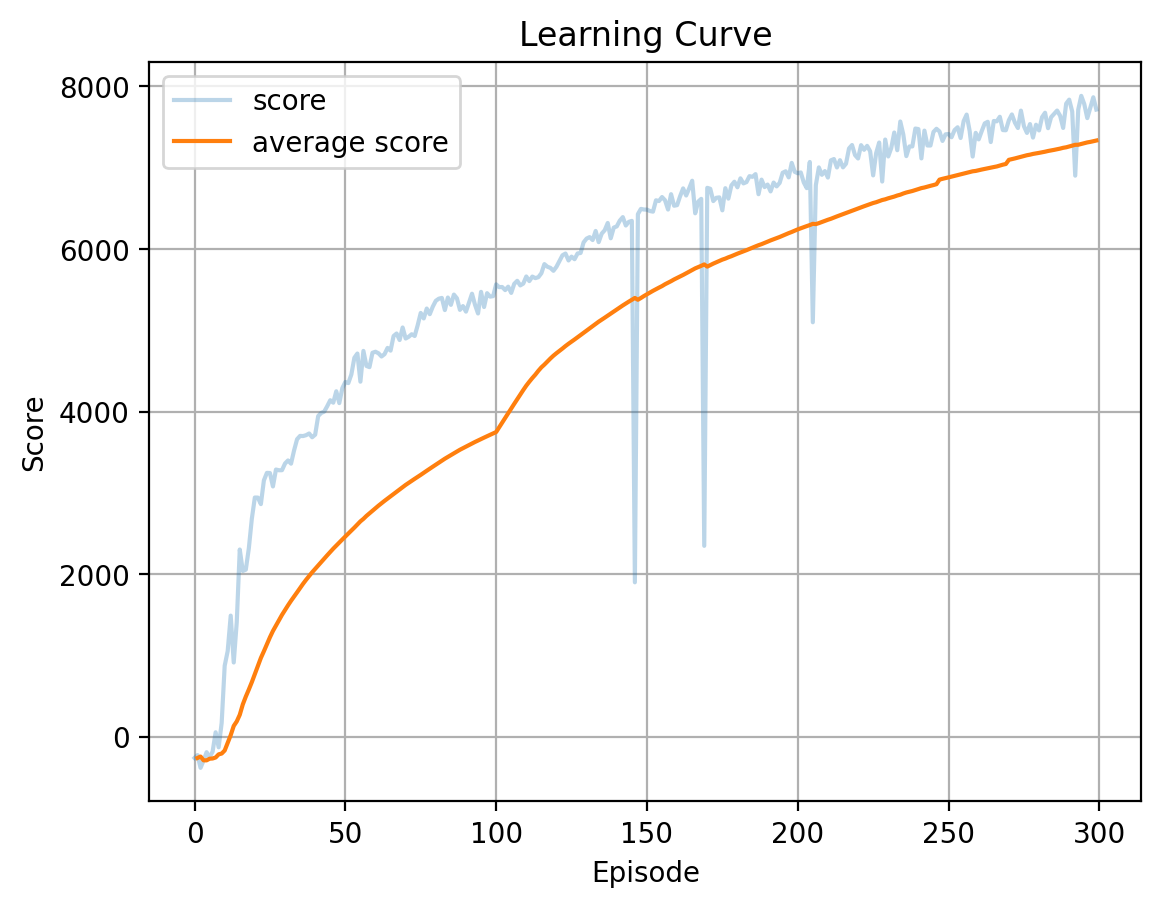

In [26]:
env = gymnasium.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta,
              state_dims=(env.observation_space.shape[0],),
              action_dims=(env.action_space.shape[0],),
              max_action=float(env.action_space.high[0]),
              fc1_dim=fc1_dim, fc2_dim=fc2_dim,
              memory_size=memory_size, batch_size=batch_size,
              tau=tau, update_period=update_period,
              reward_scale=reward_scale, warmup=warmup,
              reparam_noise_lim=reparam_noise_lim,
              name='sac', ckpt_dir=dir_path)

# --- ensure all checkpoint directories exist ---
os.makedirs(agent.full_path, exist_ok=True)
for net in [agent.actor, agent.critic_1, agent.critic_2]:
    if hasattr(net, "ckpt_path"):
        os.makedirs(os.path.dirname(net.ckpt_path), exist_ok=True)

# === tracking ===
scores, avg_scores = [], []
best_score = -np.inf

for game in trange(n_games):
    try:
        state, _ = env.reset()
    except Exception:
        state = env.reset()

    done = False
    score = 0.0

    while not done:
        action = agent.choose_action(state, deterministic=False)

        state_, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.store_transition(state, action, reward, state_, done)
        state = state_
        score += reward
        agent.total_env_steps += 1

        if agent.total_env_steps % update_period == 0:
            agent.learn()

    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    if avg_score > best_score:
        best_score = avg_score
        os.makedirs(agent.full_path, exist_ok=True)
        for net in [agent.actor, agent.critic_1, agent.critic_2]:
            if hasattr(net, "ckpt_path"):
                os.makedirs(os.path.dirname(net.ckpt_path), exist_ok=True)
        agent.save_model()

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

env.close()

plot_learning_curve(scores, agent.full_path)

In [27]:
if record_video:
    video_env = gymnasium.make(env_name, render_mode='rgb_array')
    video_env = RecordVideo(video_env, video_folder=os.path.join(dir_path, 'videos'),
                            episode_trigger=lambda ep: True)

    state, _ = video_env.reset()
    done = False
    while not done:
        action = agent.choose_action(state, deterministic=True)
        state, _, terminated, truncated, _ = video_env.step(action)
        done = terminated or truncated

    video_env.close()

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [29]:
Video(f"/content/tmp/HalfCheetah-v5/videos/rl-video-episode-0.mp4", embed=True, width=600)